In [1]:
!pip install -q datasets torch torchvision transformers matplotlib
!pip install -q pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
from tqdm import tqdm
from matplotlib import font_manager

warnings.filterwarnings('ignore')

In [3]:
# Set random seed for reproducibility
pl.seed_everything(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device: cuda


In [4]:
# Load the dataset with error handling
try:
    dataset = load_dataset("c3rl/IIIT-INDIC-HW-WORDS-Hindi")
except Exception as e:
    print(f"Failed to load dataset: {e}")
    raise

# Inspect the dataset structure
print("\nDataset features:")
print(dataset['train'].features)

# Find the correct label key
sample = dataset['train'][0]
label_key = 'label' if 'label' in sample else 'text'
print(f"Using label key: {label_key}")

# Explore the dataset
print("\nSample data:")
for i in range(3):
    sample = dataset['train'][i]
    print(f"Image shape: {sample['image'].size}, Label: {sample[label_key]}")

README.md:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/459M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/69853 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12708 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12869 [00:00<?, ? examples/s]


Dataset features:
{'image': Image(mode=None, decode=True, id=None), 'text': Value(dtype='string', id=None)}
Using label key: text

Sample data:
Image shape: (587, 293), Label: केंद्रों
Image shape: (546, 292), Label: फ़त्तू
Image shape: (642, 293), Label: सैटल


In [5]:
# Character statistics
all_labels = [sample[label_key] for sample in dataset['train']]
all_chars = [char for label in all_labels for char in label]
char_counts = Counter(all_chars)

print("\nTop 10 most common characters:")
for char, count in char_counts.most_common(10):
    print(f"{char}: {count}")

# Create character to index mapping with <UNK> token
chars = sorted(list(char_counts.keys()))
char_to_idx = {'<UNK>': 1}  # 1 for unknown token
char_to_idx.update({char: idx+2 for idx, char in enumerate(chars)})  # 0 for padding, 1 for <UNK>
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
vocab_size = len(char_to_idx) + 1  # +1 for padding token

print(f"\nVocabulary size: {vocab_size}")
print(f"Character to index mapping: {char_to_idx}")


Top 10 most common characters:
ा: 38075
र: 27660
्: 26771
न: 17642
ि: 17586
क: 16794
े: 15883
स: 15431
त: 15361
ं: 15141

Vocabulary size: 110
Character to index mapping: {'<UNK>': 1, '-': 2, 'ँ': 3, 'ं': 4, 'ः': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, '़': 59, 'ऽ': 60, 'ा': 61, 'ि': 62, 'ी': 63, 'ु': 64, 'ू': 65, 'ृ': 66, 'ॄ': 67, 'ॅ': 68, 'े': 69, 'ै': 70, 'ॉ': 71, 'ॊ': 72, 'ो': 73, 'ौ': 74, '्': 75, 'ॐ': 76, '॑': 77, '॒': 78, '॓': 79, '॔': 80, 'क़': 81, 'ख़': 82, 'ग़': 83, 'ज़': 84, 'ड़': 85, 'ढ़': 86, 'फ़': 87, 'य़': 88, 'ॠ': 89, 'ॢ': 90, '।': 91, '॥': 92, '०':

In [6]:
class HindiWordDataset(Dataset):
    def __init__(self, dataset_split, transform=None, max_label_length=25):
        self.dataset = dataset_split
        self.transform = transform
        self.max_label_length = max_label_length
        self.label_key = label_key

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item[self.label_key]

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_indices = [char_to_idx.get(char, char_to_idx['<UNK>']) for char in label]
        padded_label = torch.zeros(self.max_label_length, dtype=torch.long)
        padded_label[:len(label_indices)] = torch.tensor(label_indices)

        attention_mask = torch.zeros(self.max_label_length, dtype=torch.float32)
        attention_mask[:len(label_indices)] = 1

        return {
            'image': image,
            'label': padded_label,
            'attention_mask': attention_mask,
            'original_label': label,
            'label_length': len(label_indices)
        }


Training samples:
Please upload a Devanagari font file (e.g., NotoSansDevanagari-Regular.ttf)


Saving NotoSansDevanagari-VariableFont_wdth,wght.ttf to NotoSansDevanagari-VariableFont_wdth,wght.ttf
Successfully set font from uploaded file: NotoSansDevanagari-VariableFont_wdth,wght.ttf
Raw label[0]: निर्भर, Type: <class 'str'>, Encoded: b'\xe0\xa4\xa8\xe0\xa4\xbf\xe0\xa4\xb0\xe0\xa5\x8d\xe0\xa4\xad\xe0\xa4\xb0'
Raw label[1]: ई-केवाईसी, Type: <class 'str'>, Encoded: b'\xe0\xa4\x88-\xe0\xa4\x95\xe0\xa5\x87\xe0\xa4\xb5\xe0\xa4\xbe\xe0\xa4\x88\xe0\xa4\xb8\xe0\xa5\x80'
Raw label[2]: आखिर, Type: <class 'str'>, Encoded: b'\xe0\xa4\x86\xe0\xa4\x96\xe0\xa4\xbf\xe0\xa4\xb0'


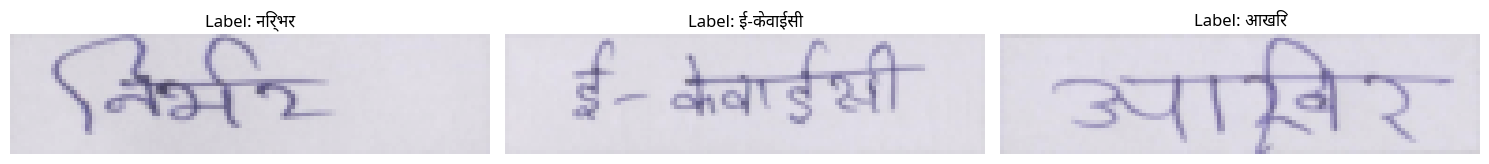

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = HindiWordDataset(dataset['train'], transform=transform)
val_dataset = HindiWordDataset(dataset['validation'], transform=transform)
test_dataset = HindiWordDataset(dataset['test'], transform=transform)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Visualize some samples
def show_samples(loader, num_samples=3):
    # Configure font for Devanagari support
    font_set = False
    default_font_paths = [
        '/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf',  # Linux default
        'C:\\Windows\\Fonts\\NotoSansDevanagari-Regular.ttf',            # Windows default
        '/Library/Fonts/NotoSansDevanagari-Regular.ttf',                # macOS default
    ]
    for font_path in default_font_paths:
        try:
            font_manager.fontManager.addfont(font_path)
            plt.rcParams['font.family'] = 'Noto Sans Devanagari'
            font_set = True
            print(f"Successfully set font from: {font_path}")
            break
        except Exception as e:
            continue

    # Fallback: Attempt to use a downloaded font in Colab or local environment
    if not font_set:
        try:
            from google.colab import files  # Import here to avoid issues if not in Colab
            print("Please upload a Devanagari font file (e.g., NotoSansDevanagari-Regular.ttf)")
            uploaded = files.upload()
            custom_font_path = list(uploaded.keys())[0]  # Use the uploaded file name
            font_manager.fontManager.addfont(custom_font_path)
            plt.rcParams['font.family'] = 'Noto Sans Devanagari'
            font_set = True
            print(f"Successfully set font from uploaded file: {custom_font_path}")
        except Exception as e:
            print(f"Warning: Failed to load uploaded font. Error: {e}")
            print("Falling back to system fonts. Ensure a Devanagari font is installed.")
            plt.rcParams['font.family'] = 'sans-serif'  # Last resort

    data_iter = iter(loader)
    batch = next(data_iter)

    num_samples = min(num_samples, len(batch['image']))
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        image = batch['image'][i].permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        # Get and debug the original label
        original_label = batch['original_label'][i]
        print(f"Raw label[{i}]: {original_label}, Type: {type(original_label)}, Encoded: {original_label.encode('utf-8', errors='replace')}")

        # Ensure label is a string and handle encoding
        if isinstance(original_label, bytes):
            label_text = original_label.decode('utf-8', errors='replace')
        else:
            label_text = str(original_label)

        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label_text}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

print("\nTraining samples:")
show_samples(train_loader)

In [8]:
class CRNN(pl.LightningModule):
    def __init__(self, vocab_size, hidden_size=256, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()

        # CNN Encoder
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))

        self.rnn = nn.LSTM(
            input_size=512,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        self.ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.cnn(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(2)
        x = x.permute(0, 2, 1)
        x, _ = self.rnn(x)
        x = self.fc(x)
        x = torch.clamp(x, min=-1e9, max=1e9)  # Prevent numerical instability
        x = nn.functional.log_softmax(x, dim=2)
        return x

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        label_lengths = batch['label_length']

        logits = self(images)
        input_lengths = torch.full(
            size=(logits.size(0),),
            fill_value=logits.size(1),
            dtype=torch.long
        )

        loss = self.ctc_loss(
            logits.permute(1, 0, 2),
            labels,
            input_lengths,
            label_lengths
        )

        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label']
        label_lengths = batch['label_length']
        original_labels = batch['original_label']

        logits = self(images)
        input_lengths = torch.full(
            size=(logits.size(0),),
            fill_value=logits.size(1),
            dtype=torch.long
        )

        loss = self.ctc_loss(
            logits.permute(1, 0, 2),
            labels,
            input_lengths,
            label_lengths
        )

        preds = self._decode_predictions(logits)
        accuracy = self._calculate_accuracy(preds, original_labels)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', accuracy, prog_bar=True)
        return {'val_loss': loss, 'val_acc': accuracy}

    def _decode_predictions(self, logits):
        _, pred_indices = torch.max(logits, dim=2)
        pred_indices = pred_indices.cpu().numpy()
        pred_texts = []
        for pred in pred_indices:
            pred_chars = []
            prev_char = None
            for idx in pred:
                if idx != 0 and idx != prev_char:
                    pred_chars.append(idx_to_char.get(idx, '<UNK>'))
                prev_char = idx
            pred_text = ''.join(pred_chars)
            pred_texts.append(pred_text)
        return pred_texts

    def _calculate_accuracy(self, preds, targets):
        correct = 0
        for pred, target in zip(preds, targets):
            if pred == target:
                correct += 1
        return correct / len(preds)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Initialize model
model = CRNN(vocab_size=vocab_size, hidden_size=256, learning_rate=0.001)
model.to(device)
print(model)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    save_top_k=1,
    dirpath='./checkpoints',
    filename='hindi-str-{epoch:02d}-{val_acc:.2f}'
)

CRNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0,

In [9]:
# Trainer
trainer = pl.Trainer(
    max_epochs=20,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
    check_val_every_n_epoch=1
)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Load best checkpoint
best_model_path = checkpoint_callback.best_model_path
if not best_model_path:
    print("No checkpoint found. Using final model state.")
else:
    print(f"Loading best model from: {best_model_path}")
    model = CRNN.load_from_checkpoint(best_model_path, vocab_size=vocab_size)
    model.to(device)
    model.eval()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | cnn           | Sequential        | 4.5 M  | train
1 | adaptive_pool | AdaptiveAvgPool2d | 0      | train
2 | rnn           | LSTM              | 3.2 M  | train
3 | fc            | Linear            | 56.4 K | train
4 | ctc_loss      | CTCLoss           | 0      | train
------------------------------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.855    Total estimated model params size (MB)
24        Modules in train mode
0         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Loading best model from: /content/checkpoints/hindi-str-epoch=16-val_acc=0.62.ckpt


In [10]:
# Test the model
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            images = batch['image'].to(model.device)
            labels = batch['label'].to(model.device)
            label_lengths = batch['label_length'].to(model.device)
            original_labels = batch['original_label']

            logits = model(images)
            input_lengths = torch.full(
                size=(logits.size(0),),
                fill_value=logits.size(1),
                dtype=torch.long,
                device=model.device
            )

            loss = model.ctc_loss(
                logits.permute(1, 0, 2),
                labels,
                input_lengths,
                label_lengths
            )

            preds = model._decode_predictions(logits)
            correct = sum(1 for pred, target in zip(preds, original_labels) if pred == target)

            total_loss += loss.item() * images.size(0)
            total_correct += correct
            total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

# Evaluate on test set
test_loss, test_acc = evaluate_model(model, test_loader)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|██████████| 202/202 [00:41<00:00,  4.91it/s]


Test Loss: 0.6507, Test Accuracy: 0.5862



Sample predictions:


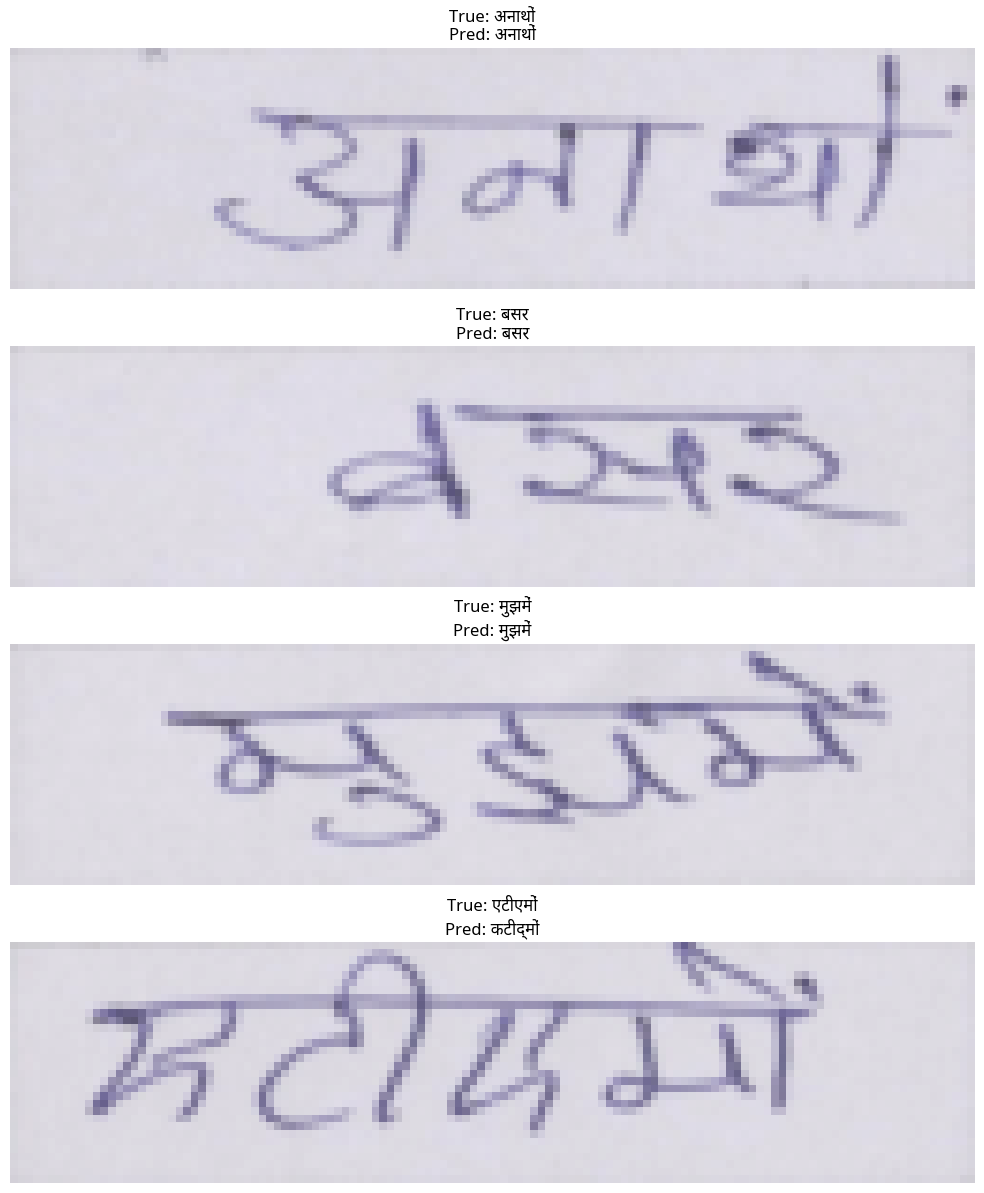

In [15]:
# Show some predictions
def show_predictions(model, loader, num_samples=5):
    model.eval()
    data_iter = iter(loader)
    batch = next(data_iter)

    images = batch['image'].to(model.device)
    original_labels = batch['original_label']
    num_samples = min(num_samples, len(images))

    with torch.no_grad():
        logits = model(images)
        preds = model._decode_predictions(logits)

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, num_samples*3))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        image = images[i].cpu().permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].set_title(f"True: {original_labels[i]}\nPred: {preds[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nSample predictions:")
show_predictions(model, test_loader, num_samples=4)


User Input Prediction:
Please upload an image of handwritten Hindi text (e.g., JPG or PNG)


Saving telugu.png to telugu.png


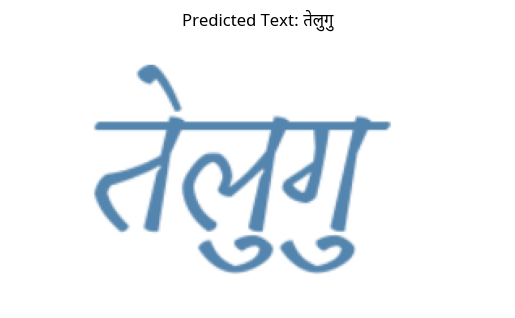

Predicted Text: तेलुगु


In [18]:
# User input and prediction section
def predict_handwritten_text():
    from google.colab import files
    print("Please upload an image of handwritten Hindi text (e.g., JPG or PNG)")
    uploaded = files.upload()
    image_path = list(uploaded.keys())[0]

    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(img)
        pred_indices = torch.max(logits, dim=2)[1].squeeze().cpu().numpy()
        pred_chars = []
        prev_char = None
        for idx in pred_indices:
            if idx != 0 and idx != prev_char:
                pred_chars.append(idx_to_char.get(idx, '<UNK>'))
            prev_char = idx
        predicted_text = ''.join(pred_chars)

    # Display the image and prediction
    plt.imshow(np.array(Image.open(image_path)))
    plt.title(f"Predicted Text: {predicted_text}")
    plt.axis('off')
    plt.show()
    print(f"Predicted Text: {predicted_text}")

# Run the prediction function
print("\nUser Input Prediction:")
predict_handwritten_text()

In [19]:
!zip -r /content/all_files.zip /content/
from google.colab import files
files.download("/content/all_files.zip")

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/gce (stored 0%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/.last_survey_prompt.yaml (stored 0%)
updating: content/.config/.last_update_check.json (deflated 23%)
updating: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
updating: content/.config/config_sentinel (stored 0%)
updating: content/.config/configurations/ (stored 0%)
updating: content/.config/configurations/config_default (deflated 15%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.04.17/ (stored 0%)
updating: content/.config/logs/2025.04.17/13.36.23.688038.log (deflated 57%)
updating: content/.config/logs/2025.04.17/13.36.05.735198.log (deflated 58%)
updating: content/.config/logs/2025.04.17/13.36.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>